<a href="https://colab.research.google.com/github/Thiru2208/CM2607_CW/blob/main/2425449_20241152_CM2607_CW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from numpy.fft import rfft, rfftfreq
import cv2

1. Modelling Travel Time

In [27]:
#Define Symbols
x, y = sp.symbols('x y', positive = True, real = True)
a, b, c = sp.symbols ('a  b c', positive = True, real = True)

#Travel time modela
Tb = a*x**2 + b*y**2
Tt = sp.sqrt(c*(x**2 + y**2))

Tb, Tt

(a*x**2 + b*y**2, sqrt(c)*sqrt(x**2 + y**2))

In [19]:
# Compute gradients
dTb_dx = sp.diff(Tb, x)
dTb_dy = sp.diff(Tb, y)
dTt_dx = sp.diff(Tt, x)
dTt_dy = sp.diff(Tt, y)

grad_Tb = (sp.simplify(dTb_dx), sp.simplify(dTb_dy))
grad_Tt = (sp.simplify(dTt_dx), sp.simplify(dTt_dy))

print("Gradient for bus is ",grad_Tb)
print("Gradient for Taxi is ",grad_Tt)

Gradient for bus is  (2*a*x, 2*b*y)
Gradient for Taxi is  (sqrt(c)*x/sqrt(x**2 + y**2), sqrt(c)*y/sqrt(x**2 + y**2))


In [20]:
# ----- Numeric evaluation helper -----
x0 = 4.5  # given route distance (approx)

# Example parameters (CHANGE these to your chosen assumptions later)
a0 = 2.0
b0 = 1.0
c0 = 9.0

# Choose a few traffic delay values (min/km)
y_values = [1, 3, 6]

# Substitute and evaluate partial derivatives at (x0, y)
for y0 in y_values:
    bus_dx = float(dTb_dx.subs({a:a0, x:x0}))
    bus_dy = float(dTb_dy.subs({b:b0, y:y0}))

    taxi_dx = float(dTt_dx.subs({c:c0, x:x0, y:y0}))
    taxi_dy = float(dTt_dy.subs({c:c0, x:x0, y:y0}))

    print(f"\nAt x={x0} km, y={y0} min/km")
    print(f"Bus:  ∂Tb/∂x = {bus_dx:.3f},  ∂Tb/∂y = {bus_dy:.3f}")
    print(f"Taxi: ∂Tt/∂x = {taxi_dx:.3f},  ∂Tt/∂y = {taxi_dy:.3f}")



At x=4.5 km, y=1 min/km
Bus:  ∂Tb/∂x = 18.000,  ∂Tb/∂y = 2.000
Taxi: ∂Tt/∂x = 2.929,  ∂Tt/∂y = 0.651

At x=4.5 km, y=3 min/km
Bus:  ∂Tb/∂x = 18.000,  ∂Tb/∂y = 6.000
Taxi: ∂Tt/∂x = 2.496,  ∂Tt/∂y = 1.664

At x=4.5 km, y=6 min/km
Bus:  ∂Tb/∂x = 18.000,  ∂Tb/∂y = 12.000
Taxi: ∂Tt/∂x = 1.800,  ∂Tt/∂y = 2.400


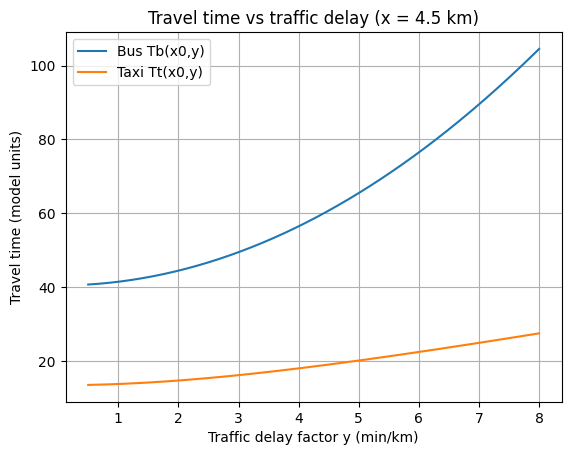

In [21]:
ys = np.linspace(0.5, 8.0, 250)

Tb_num = a0*(x0**2) + b0*(ys**2)
Tt_num = np.sqrt(c0*((x0**2) + (ys**2)))

plt.figure()
plt.plot(ys, Tb_num, label="Bus Tb(x0,y)")
plt.plot(ys, Tt_num, label="Taxi Tt(x0,y)")
plt.xlabel("Traffic delay factor y (min/km)")
plt.ylabel("Travel time (model units)")
plt.title("Travel time vs traffic delay (x = 4.5 km)")
plt.grid(True)
plt.legend()
plt.show()


In [22]:
print("""In the bus model Tb = a*x^2 + b*y^2, the gradient components 2*a*x and 2*b*y show that distance affects travel time at a constant rate for a fixed route, while the impact of traffic delay increases in proportion to y. This means that under light traffic, distance contributes more to the bus travel time, but as congestion increases, the term 2*b*y becomes dominant, making traffic delay the stronger factor. For the taxi model Tt = sqrt(c*(x^2 + y^2)), the gradient distributes the influence of distance and delay through the common denominator sqrt(x^2 + y^2). When traffic delay is small, both distance and delay contribute similarly, but as y grows larger, the sensitivity dTt/dy overtakes dTt/dx. Therefore, taxi travel time becomes increasingly influenced by heavy traffic, showing that congestion affects both modes but impacts the bus more sharply at high delay levels.""")

In the bus model Tb = a*x^2 + b*y^2, the gradient components 2*a*x and 2*b*y show that distance affects travel time at a constant rate for a fixed route, while the impact of traffic delay increases in proportion to y. This means that under light traffic, distance contributes more to the bus travel time, but as congestion increases, the term 2*b*y becomes dominant, making traffic delay the stronger factor. For the taxi model Tt = sqrt(c*(x^2 + y^2)), the gradient distributes the influence of distance and delay through the common denominator sqrt(x^2 + y^2). When traffic delay is small, both distance and delay contribute similarly, but as y grows larger, the sensitivity dTt/dy overtakes dTt/dx. Therefore, taxi travel time becomes increasingly influenced by heavy traffic, showing that congestion affects both modes but impacts the bus more sharply at high delay levels.


2. Cost Analysis Using Integration

In [23]:
# Problem 2 - Symbolic Integration

# Define symbols
t = sp.symbols('t', real=True)
x_sym = sp.symbols('x', nonnegative=True, real=True)

# Cost-rate functions
rate_bus = 2*t + 1
rate_taxi = 3*t + 2

# Integrate from 0 to x
Fb_expr = sp.integrate(rate_bus, (t, 0, x_sym))
Ft_expr = sp.integrate(rate_taxi, (t, 0, x_sym))

Fb_expr, Ft_expr


(x**2 + x, 3*x**2/2 + 2*x)

In [24]:
# Convert symbolic expressions into numeric functions
Fb = sp.lambdify(x_sym, Fb_expr, 'numpy')
Ft = sp.lambdify(x_sym, Ft_expr, 'numpy')


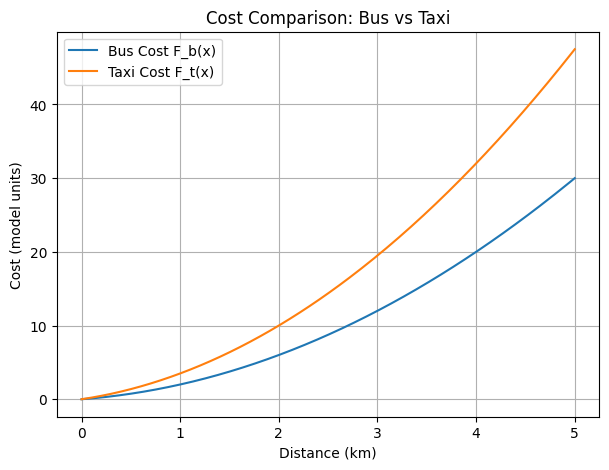

In [25]:
# Distance values 0–5 km
xs = np.linspace(0, 5, 200)

plt.figure(figsize=(7,5))
plt.plot(xs, Fb(xs), label="Bus Cost F_b(x)")
plt.plot(xs, Ft(xs), label="Taxi Cost F_t(x)")
plt.xlabel("Distance (km)")
plt.ylabel("Cost (model units)")
plt.title("Cost Comparison: Bus vs Taxi")
plt.grid(True)
plt.legend()
plt.show()


In [26]:
print("""When we look at the integrated cost functions for the bus and taxi, the bus cost
Fb(x) = x + x^2
grows more slowly because both the linear and quadratic parts are smaller. The taxi cost
Ft(x) = 2x + 3/2 x^2
increases faster, since it starts with a higher basic rate and its squared term also has a bigger coefficient. For short distances, the difference between the two costs isn’t very large, but as the distance increases, the taxi price rises much more quickly than the bus price. This shows that the bus remains the cheaper option overall, especially for longer trips, because the cost growth is slower compared to the taxi.
""")

When we look at the integrated cost functions for the bus and taxi, the bus cost
Fb(x) = x + x^2
grows more slowly because both the linear and quadratic parts are smaller. The taxi cost
Ft(x) = 2x + 3/2 x^2
increases faster, since it starts with a higher basic rate and its squared term also has a bigger coefficient. For short distances, the difference between the two costs isn’t very large, but as the distance increases, the taxi price rises much more quickly than the bus price. This shows that the bus remains the cheaper option overall, especially for longer trips, because the cost growth is slower compared to the taxi.



3. Predicting Peak Travel Times Using Series Convergence

In [30]:
t = sp.symbols("t", real =True)

# First term of sin(pi*t) series
sin_approx_1 = sp.series(sp.sin(sp.pi*t), t, 0, 2).removeO()  # gives πt
sin_approx_1

pi*t

In [31]:
P4 = 5 + 4*sin_approx_1 - sp.Rational(3,2)*t**2 + sp.Rational(1,4)*t**4
P4_s = sp.simplify(P4)
P4_s


t**4/4 - 3*t**2/2 + 4*pi*t + 5

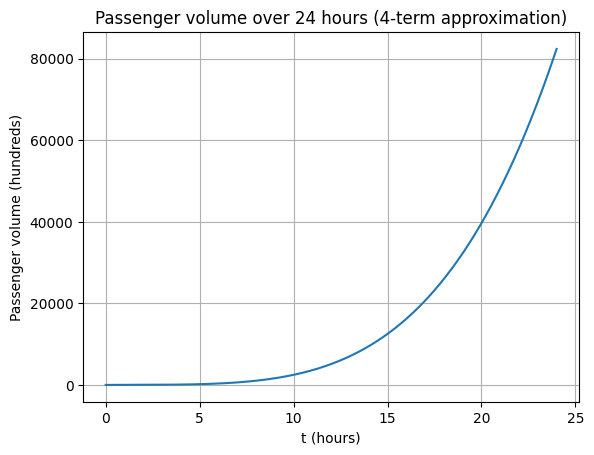

In [32]:
P_fun = sp.lambdify(t, P4_s, "numpy")
ts = np.linspace(0, 24, 2000)
vals = P_fun(ts)

plt.figure()
plt.plot(ts, vals)
plt.xlabel("t (hours)")
plt.ylabel("Passenger volume (hundreds)")
plt.title("Passenger volume over 24 hours (4-term approximation)")
plt.grid(True)
plt.show()

In [33]:
k = 5
top_idx = np.argsort(vals)[-k:][::-1]
for i in top_idx:
    print(f"t={ts[i]:.2f} h,  P={vals[i]:.3f}")


t=24.00 h,  P=82386.593
t=23.99 h,  P=82221.460
t=23.98 h,  P=82056.575
t=23.96 h,  P=81891.938
t=23.95 h,  P=81727.550
